In [1]:
import sys, os
import numpy as np
import pandas as pd
from geopandas import GeoDataFrame
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pdb
from joblib import Parallel, delayed
import multiprocessing
from scipy.stats import entropy
from datetime import datetime, timedelta
import epiweeks as epi
from scipy.stats import pearsonr
from scipy.signal import correlate
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.fftpack import fft, ifft
from scipy.optimize import nnls
import scipy.stats as stats
from scipy.optimize import leastsq
from scipy.signal import savgol_filter
from collections import defaultdict
import statsmodels.api as sm
from tqdm import tqdm_notebook as tqdm
import matplotlib.dates as mdates
# from matplotlib.dates import mdates

In [2]:
def get_week(date, weeks):
    for week in weeks:
        s,e = week.split('_')
        if s <= date and date <= e:
            return week

fipsdf=pd.read_csv('../misc_data/US_fips_codes_names.csv')
fipsdf['FIPS']=fipsdf.FIPS.apply(lambda x: '{:05}'.format(x))
mapfips=dict(zip(fipsdf['FIPS'],fipsdf['County']+'_'+fipsdf['name']))
mapname=dict(zip(fipsdf['County']+'_'+fipsdf['name'],fipsdf['FIPS']))

goog_dates=[]
with open('input/goog_dates.txt','r') as f:
    for line in f:
        goog_dates.append(line[:-1])
goog_dates
stdt=goog_dates[-1].split('_')[0]
for i in range(1,40):
    dt0=(datetime.strptime(stdt,'%Y-%m-%d')+timedelta(weeks=i)).strftime('%Y-%m-%d')
    dt1=(datetime.strptime(dt0,'%Y-%m-%d')+timedelta(days=6)).strftime('%Y-%m-%d')
    goog_dates.append(dt0+'_'+dt1)

sorted(goog_dates)[-1]

'2023-06-18_2023-06-24'

In [3]:
file="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
df = pd.read_csv(file,header=0,dtype={'UID':str,'code3':str,'FIPS':str})
df=df.dropna(subset=['FIPS'])
df.loc[:,'FIPS']=df.FIPS.apply(lambda x : '{:05}'.format(int(float(x))))
all_dict={}
for st in df.Province_State:
        all_dict[st]=dict(zip(df[df.Province_State==st]['FIPS'],df[df.Province_State==st]['Admin2']))
df.drop(columns=['Country_Region','Lat','Long_','iso2','iso3','UID','code3','Admin2','Combined_Key','Province_State'],inplace=True)
agg_df=df.dropna(subset=['FIPS'])
agg_df.loc[:,'FIPS']=agg_df.FIPS.astype(float)
agg_df.FIPS=agg_df.FIPS.apply(lambda x: '{:05}'.format(int(x)))
# agg_df = df.groupby(['Province_State']).agg(np.sum)
dates = agg_df.iloc[:,1:].columns.tolist()
dates = [datetime.strptime(x, '%m/%d/%y') for x in dates]
dates = [x.strftime('%Y-%m-%d') for x in dates]
agg_df.iloc[:,1:].columns = dates
for x in agg_df.iloc[:,1:].columns:
    agg_df=agg_df.rename(columns={x:datetime.strptime(x, '%m/%d/%y').strftime('%Y-%m-%d')})
# agg_df.loc[:,'admin_st']=agg_df.Admin2+'_'+agg_df.Province_State
# agg_df=agg_df.drop(columns=['Admin2','Province_State'])
agg_df=agg_df.set_index('FIPS')
# dates = agg_df.columns
agg_df.groupby((np.arange(len(agg_df.columns)) // 7) + 1, axis=1).sum().add_prefix('s')
agg_df.columns = [get_week(x,goog_dates) for x in dates]
agg_df = agg_df.groupby(agg_df.columns,axis=1).max()
dates = agg_df.columns.values.tolist()
new_df = agg_df.copy()
for i in range(len(dates)):
    d, prev_d = dates[i], dates[i-1]
    new_df[d] = agg_df[d] - agg_df[prev_d]
    
covid_df = new_df.copy()
covid_dates = dates

# agg_df.index=agg_df.index.map(mapname)
# agg_df=agg_df[agg_df.index.notna()]
# new_df.index=new_df.index.map(mapname)
# new_df=new_df[new_df.index.notna()]

for col in agg_df.columns:
    agg_df=agg_df.rename(columns={col:col.split('_')[0]})
for col in new_df.columns:
    new_df=new_df.rename(columns={col:col.split('_')[0]})
    

for col in new_df.columns:
    new_df=new_df.rename(columns={col:datetime.strptime(col,'%Y-%m-%d').date()})

diff_df=new_df.diff(axis=1).fillna(0)
data_df=np.log(new_df.mask(new_df<=0)).fillna(0)#diff_df

new_df[new_df<=0]=1

for col in new_df.columns:
    if col=='FIPS':
        continue
    else:
        new_df=new_df.rename(columns={col:col.strftime('%Y-%m-%d')})
newdf=new_df.reset_index()
cols=new_df.columns
mnewdf=pd.melt(newdf,id_vars=['FIPS'], value_vars=cols,
        var_name='fct_date', value_name='true')
mnewdf=mnewdf.rename(columns={'FIPS':'cnty'})

In [4]:
mnewdf.to_csv('csv/case_data.csv',index=None)

In [5]:
sorted(mnewdf.fct_date.unique())

['2020-01-19',
 '2020-01-26',
 '2020-02-02',
 '2020-02-09',
 '2020-02-16',
 '2020-02-23',
 '2020-03-01',
 '2020-03-08',
 '2020-03-15',
 '2020-03-22',
 '2020-03-29',
 '2020-04-05',
 '2020-04-12',
 '2020-04-19',
 '2020-04-26',
 '2020-05-03',
 '2020-05-10',
 '2020-05-17',
 '2020-05-24',
 '2020-05-31',
 '2020-06-07',
 '2020-06-14',
 '2020-06-21',
 '2020-06-28',
 '2020-07-05',
 '2020-07-12',
 '2020-07-19',
 '2020-07-26',
 '2020-08-02',
 '2020-08-09',
 '2020-08-16',
 '2020-08-23',
 '2020-08-30',
 '2020-09-06',
 '2020-09-13',
 '2020-09-20',
 '2020-09-27',
 '2020-10-04',
 '2020-10-11',
 '2020-10-18',
 '2020-10-25',
 '2020-11-01',
 '2020-11-08',
 '2020-11-15',
 '2020-11-22',
 '2020-11-29',
 '2020-12-06',
 '2020-12-13',
 '2020-12-20',
 '2020-12-27',
 '2021-01-03',
 '2021-01-10',
 '2021-01-17',
 '2021-01-24',
 '2021-01-31',
 '2021-02-07',
 '2021-02-14',
 '2021-02-21',
 '2021-02-28',
 '2021-03-07',
 '2021-03-14',
 '2021-03-21',
 '2021-03-28',
 '2021-04-04',
 '2021-04-11',
 '2021-04-18']

In [6]:
tdf=pd.DataFrame()
for mtd in ['AR_spatial','AR','ARIMA','PatchSim','kalman','lstm']:#,'PatchSim','kalman','lstm','lstm_snapshot']:#'AR_spatial_mob','mob',,'AR_spatial_mob','lstm_snapshot','AR_exog'
    tdf=tdf.append(pd.read_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/{}/merged.csv'.format(mtd)))

tdf.cnty=pd.to_numeric(tdf.cnty)
tdf.cnty=tdf.cnty.apply(lambda x: '{:05}'.format(int(x)))

/home/aa5dw/.local/lib/python3.6/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [7]:
for mtd in tdf.method.unique():
    print(mtd,tdf[tdf.method==mtd]['horizon'].max())

AR_spatial 2021-03-14
AR 2021-03-14
ARIMA 2021-03-14
PatchSim_adpt 2021-03-14
ENKF 2021-03-14
lstm 2021-03-14


In [8]:
# tdf.to_csv('output/all_methods_merged_2021-01-17.csv',index=None)

In [9]:
tdf=tdf.merge(mnewdf,on=['cnty','fct_date'],how='outer')

In [11]:
sorted(tdf[tdf.horizon=='2021-03-14'].fct_date.unique())

['2021-03-21', '2021-03-28', '2021-04-04', '2021-04-11']

In [14]:
def include_methods(tdf):
    iterables = [tdf['horizon'].unique(),tdf['method'].unique(),tdf['cnty'].unique(),tdf['step_ahead'].unique()]
    ind1=pd.MultiIndex.from_product(iterables, names=['horizon', 'method','cnty','step_ahead'])
    ktdf=pd.DataFrame(index=ind1)
    ktdf['temp']=np.nan
    ktdf=ktdf.reset_index()
    ktdf['hrzn_step']=ktdf['step_ahead'].str[:1].astype(int)
    ktdf['fct_date']=(pd.to_datetime(ktdf['horizon'],format='%Y-%m-%d')+pd.to_timedelta(ktdf['hrzn_step'],unit='W')).dt.strftime('%Y-%m-%d')
    ptdf=tdf.merge(ktdf,how='right',on=['cnty','horizon','method','step_ahead','fct_date'])
    ptdf=ptdf.drop(['temp','hrzn_step'],axis=1)
    return ptdf

In [15]:
# tdf=include_methods(tdf)

In [16]:
dictfips=pd.read_csv('input/fips_map.csv',dtype={'FIPS':str,'St_code':str})

In [17]:
popdf=pd.read_csv('https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-locations/locations.csv')
popdf=popdf[['location','population']].rename(columns={'location':'FIPS'}).merge(dictfips[['FIPS','location_name','cnty']],on='FIPS')

In [18]:

cnlist=popdf.sort_values('population',ascending=False)['FIPS'][:10].values

In [19]:
def get_win(dt,win):
    return (datetime.strptime(dt,'%Y-%m-%d')-timedelta(weeks=win)).strftime('%Y-%m-%d')

In [20]:
# wdf=pd.read_csv('output/all_weeks_wts_newcomp.csv')
# wdf=wdf.drop(['Unnamed: 0'],axis=1)
# wdf['cnty']=pd.to_numeric(wdf.cnty)
# wdf['cnty']=wdf.cnty.apply(lambda x: '{:05}'.format(int(x)))

In [21]:
# owdf['cnty']=pd.to_numeric(owdf.cnty)
# owdf['cnty']=owdf.cnty.apply(lambda x: '{:05}'.format(int(x)))

In [24]:
tdf=tdf.merge(popdf[['FIPS','population']].rename(columns={'FIPS':'cnty'}),on='cnty')

In [25]:
# tdf['pk_fct_mean']=100e3*tdf['fct_mean']/tdf['population']
# tdf['pk_fct_std']=100e3*tdf['fct_std']/tdf['population']
# tdf['pk_true']=100e3*tdf['true']/tdf['population']

# tdf['fct_rel']=tdf['fct_mean']/tdf['true']
# tdf['true_rel']=tdf['true']/tdf['true']

indp=tdf[tdf.fct_mean>=tdf.population].index
tdf.loc[indp,'fct_mean']=np.nan

In [26]:
tdf['set_type']=tdf['cnty']+'_'+tdf['method']+'_'+tdf['step_ahead']

In [27]:
# # tdf.loc[:,'min_fct_lb']=
# tmindf=tdf.groupby(['cnty','horizon','step_ahead','fct_date'],as_index=False)['fct_lb'].min()[['cnty','horizon','fct_date','fct_lb']]
# tmaxdf=tdf.groupby(['cnty','horizon','step_ahead','fct_date'],as_index=False)['fct_ub'].max()[['cnty','horizon','fct_date','fct_ub']]

# # tdf.loc[:,'max_fct_lb']=tdf.groupby(['cnty','horizon','step_ahead','fct_date','method'],as_index=False)['fct_ub'].max()['fct_ub']

### Multiple variants to deriving weights

In [22]:
# ll=['2021-01-31', '2021-01-24', '2021-01-17', '2021-01-10',
#        '2021-01-03', '2020-12-27', '2020-12-20', '2020-12-13',
#        '2020-12-06', '2020-11-29', '2020-11-22', '2020-11-15',
#        '2020-11-08', '2020-11-01', '2020-10-25', '2020-10-18',
#        '2020-10-11', '2020-10-04', '2020-09-27', '2020-09-20',
#        '2020-09-13', '2020-09-06', '2020-08-30', '2020-08-23',
#        '2020-08-16', '2020-08-09', '2020-08-02', '2020-07-26',
#        '2020-07-19', '2020-07-12', '2020-07-05', '2020-06-28',
#        '2020-06-21', '2020-06-14', '2020-06-07', '2020-05-31',
#        '2020-05-24', '2020-05-17', '2020-05-10', '2020-05-03',
#        '2020-04-26', '2020-04-19', '2020-04-12', '2020-04-05']
# tdf[~tdf.horizon.isin(ll)]

In [312]:
ind=tdf[tdf['fct_std'].isna()].index
tdf.loc[ind,'fct_std']=(tdf.loc[ind,'fct_ub']-tdf.loc[ind,'fct_lb'])/3.92
col_M=['cnty','step_ahead','method','sig']
col_W=['cnty','step_ahead','method','wts']
col_E=['cnty','horizon','fct_date','step_ahead','z_denom']
col='fct_mean'
coladj='fct_mean'#'fct_mean','pk_fct_mean'
coltrue='true'
colstd='fct_std'
col_F=['cnty','step_ahead','method',coladj]
win=4
dtlist=tdf[(tdf.horizon=='2021-02-07')].horizon.unique()#&(tdf.horizon>='2020-08-01')](tdf.horizon<='2021-01-17')&&(tdf.horizon>='2020-08-01')
wdf=pd.DataFrame()
for sdt in tqdm(sorted(dtlist)):#&(tdf.horizon>='2020-08-01')
    edt=get_win(sdt,win)
    tempdf=tdf[(tdf.horizon<sdt)&(tdf.horizon>=edt)][['cnty','horizon','fct_date','step_ahead','method','set_type',coltrue,col,colstd]]
    setlist=tdf[(tdf.horizon==sdt)]['set_type'].unique()
    tempdf=tempdf[tempdf['set_type'].isin(setlist)]
    tempdf.loc[tempdf.index,'sig']=tempdf.loc[tempdf.index,colstd]
    tempdf.loc[tempdf.index,coladj]=tempdf.loc[tempdf.index,col]
    tempdf.loc[:,'wts']=1/len(tempdf.method.unique())
    # x1=[];x2=np.zeros(len(tempdf.method.unique()))
    for i in range(50):
        # E-step
#         tempdf['mse']=(tempdf[coltrue]-tempdf[col])**2
#         tempdf['gauss']=np.exp(-((tempdf[coltrue]-tempdf[col])/(np.sqrt(2)*tempdf['sig']))**2)*np.sqrt((1/(2*np.pi*tempdf['sig']**2)))
        tempdf.loc[tempdf.index,'z_num']=tempdf['wts']*np.exp(-((tempdf[coltrue]-tempdf[coladj])/(np.sqrt(2)*tempdf['sig']))**2)*np.sqrt((1/(2*np.pi*tempdf['sig']**2)))
        z_denom=tempdf.groupby(['cnty','horizon','fct_date','step_ahead'],as_index=False).sum().rename(columns={'z_num':'z_denom'})
        z_denom=z_denom[['cnty','horizon','fct_date','step_ahead','z_denom']]
        z_denom.loc[z_denom.index,'z_denom']+=1e-12
        tempdf=tempdf.merge(z_denom,on=['cnty','horizon','fct_date','step_ahead'])
    #     tempdf=tempdf.drop(['sig'],axis=1)
        tempdf.loc[tempdf.index,'z']=tempdf.loc[tempdf.index,'z_num']/tempdf.loc[tempdf.index,'z_denom']
        tempdf=tempdf.drop(['sig','z_denom','wts'],axis=1)

        # M-step
        tempdf.loc[tempdf.index,'sig_num']=tempdf.loc[tempdf.index,'z']*(tempdf[col]-tempdf[coltrue])**2
        tempdf.loc[tempdf.index,'fct_num']=tempdf.loc[tempdf.index,'z']*(tempdf[coltrue])
#         fct_temp=tempdf.groupby(['cnty','method','step_ahead'],as_index=False).sum()
#         fct_temp['fct_adj']=fct_temp['fct_num']/fct_temp['z']
        sig_temp=tempdf.groupby(['cnty','method','step_ahead'],as_index=False).sum()
#         sig_temp['sig_num']=sig_temp['sig']
        sig_temp.loc[sig_temp.index,'sig']=np.sqrt(sig_temp['sig_num'])
        w_temp=tempdf.groupby(['cnty','step_ahead','method'],as_index=False).mean().rename(columns={'z':'wts'})
#         w_temp['horizon']=sdt
#         tempdf=tempdf.drop(['wts'],axis=1)
        tempdf=tempdf.merge(w_temp[col_W],on=['cnty','method','step_ahead'],how='outer')
        tempdf=tempdf.merge(sig_temp[col_M],on=['cnty','method','step_ahead'],how='outer')
#         tempdf=tempdf.merge(fct_temp[col_F],on=['cnty','method','step_ahead'],how='outer')
    w_temp=w_temp[col_W].merge(sig_temp[col_M])
#     w_temp=w_temp.merge(fct_temp[col_F])
    w_temp['horizon']=sdt
    wdf=wdf.append(w_temp,sort=True)
#     x1=x2.copy()
#     x2=w_temp['z'].values
#     err=np.linalg.norm(x2-x1)**2

#     w_temp['horizon']=sdt
#     sig_temp['horizon']=sdt
#     w_temp=w_temp.merge(sig_temp[['cnty','step_ahead','method','sig','horizon']],on=['cnty','step_ahead','horizon','method'])
#     wdf=wdf.append(w_temp,sort=True)
#     print(i,w_temp['z'].values,err)
#     if err<=1e-6:
#         break
    # tempdf.loc[tempdf.index,'sig']=sig_temp['']
wdf['wts']=wdf['wts'].fillna(0)
# twdf=wdf.groupby(['cnty','horizon','step_ahead'],as_index=False).sum()[['cnty','horizon','step_ahead','wts']]
# twdf=twdf.rename(columns={'wts':'wts_sum'})
# wdf=wdf.merge(twdf, on=['cnty','horizon','step_ahead'])
# wdf['wts']=wdf['wts']/wdf['wts_sum']
# wdf=wdf.drop(['wts_sum'],axis=1)
wdf.to_csv('output/all_weeks_wts_newcomp_true_{}.csv'.format(sdt),index=None)
# #     wdf['wts']=wdf['wts'].fillna(0)

In [48]:
for mtd in tdf.method.unique():
    print(mtd,tdf[tdf.method==mtd]['horizon'].max())

AR_spatial 2021-02-14
AR 2021-02-14
ARIMA 2021-02-14
PatchSim_adpt 2021-02-14
ENKF 2021-02-14
lstm 2021-02-14


In [49]:
# # tdf[(tdf.cnty=='01001')&(tdf.horizon=='2020-08-02')]
# wdf.groupby(['cnty','horizon','step_ahead']).sum()
# # tdf[(tdf.cnty=='01001')&(tdf.horizon=='2020-08-09')&(tdf.step_ahead=='2-step_ahead')]


In [50]:
# owdf=pd.read_csv('output/all_weeks_wts_newcomp_true.csv',dtype={'cnty':str})

In [272]:
with open('input/date_file.txt','w') as f:
    for l in dtlist:
        f.writelines('%s\n' % l)
        
with open('input/mtd_file.txt','w') as f:
    for l in tdf.method.unique():
        f.writelines('%s\n' % l)

In [273]:
# owdf[(owdf.cnty=='01001')&(owdf.horizon=='2020-08-02')]

In [274]:
# %%bash
# dt_list="input/date_file.txt"                                                                       
# #input_cnty="../input/va_cnty_list.txt"                                                             
# mtd_list="input/mtd_file.txt"                                                                       
# while IFS= read -r hrzn                                                                             
# do                                                                                                  
#     while IFS= read -r mtd                                                                          
#     do                                                                                              
#         echo $mtd $hrzn                                                                             
#         mv output/all_weeks_wts_newcomp_no_${mtd}_${hrzn}.csv output/ablation/                                                              
#             #qreg                                                                                   
#     done < $mtd_list                                                                                
# done < $dt_list  

### get bma from weight df

##### merge weight df

In [7]:
tdf=pd.DataFrame()
for mtd in ['AR_spatial','AR','ARIMA','PatchSim','PatchSim_B117','kalman','lstm']:#, 'PatchSim_B117','PatchSim','kalman','lstm','lstm_snapshot']:#'AR_spatial_mob','mob',,'AR_spatial_mob','lstm_snapshot','AR_exog'
    tdf=tdf.append(pd.read_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/{}/merged.csv'.format(mtd)))

tdf.cnty=pd.to_numeric(tdf.cnty)
tdf.cnty=tdf.cnty.apply(lambda x: '{:05}'.format(int(x)))

In [8]:
hrzndt='2021-04-11'

In [9]:
dtlist=tdf[(tdf.horizon<=hrzndt)&(tdf.horizon>='2020-08-01')].horizon.unique()

In [10]:
sorted(dtlist)

['2020-08-02',
 '2020-08-09',
 '2020-08-16',
 '2020-08-23',
 '2020-08-30',
 '2020-09-06',
 '2020-09-13',
 '2020-09-20',
 '2020-09-27',
 '2020-10-04',
 '2020-10-11',
 '2020-10-18',
 '2020-10-25',
 '2020-11-01',
 '2020-11-08',
 '2020-11-15',
 '2020-11-22',
 '2020-11-29',
 '2020-12-06',
 '2020-12-13',
 '2020-12-20',
 '2020-12-27',
 '2021-01-03',
 '2021-01-10',
 '2021-01-17',
 '2021-01-24',
 '2021-01-31',
 '2021-02-07',
 '2021-02-14',
 '2021-02-21',
 '2021-02-28',
 '2021-03-07',
 '2021-03-14',
 '2021-03-21',
 '2021-03-28',
 '2021-04-04',
 '2021-04-11']

In [11]:
tmpwdf=pd.DataFrame()
for dt in tqdm(dtlist):
    tmpwdf=tmpwdf.append(pd.read_csv('output/weights/all_weeks_wts_newcomp_true_{}.csv'.format(dt),dtype={'cnty':str}))
tmpwdf.to_csv('output/all_weeks_wts_newcomp_true_v5.csv'.format(mtd),index=None)

In [13]:
bmadf=pd.DataFrame()
for w in ['true']:
    print(w)
    temp=pd.read_csv('output/all_weeks_wts_newcomp_true_v5.csv',dtype={'cnty':str})
    temp=temp.rename(columns={'wts':'wts_{}'.format(w),'sig':'sig_{}'.format(w)})
    wtdf=tdf.merge(temp)
    wtdf.loc[wtdf[wtdf.fct_lb<0].index,'fct_lb']=0
    wtdf.loc[wtdf[wtdf.fct_ub<0].index,'fct_ub']=0
    if w=='adj':
        coltemp='fct_adj'
    elif w=='true':
        coltemp='fct_mean'
    wtdf['w_fct_mean']=wtdf[coltemp]*wtdf['wts_{}'.format(w)]
#     wtdf['true']=wtdf['true']*wtdf['wts_{}'.format(w)]
    wtdf['sig_2']=wtdf['wts_{}'.format(w)]*wtdf['sig_{}'.format(w)]**2
    wtdf['w_fct_mean_2']=wtdf['wts_{}'.format(w)]*wtdf['fct_mean'.format(w)]**2
    wttdf=wtdf.groupby(['cnty','horizon','fct_date','step_ahead'],as_index=False).sum()
    wttdf['w_sig_2']=(wttdf['sig_2']+wttdf['w_fct_mean_2']-wttdf['w_fct_mean']**2)
    wttdf['method']='BMA-ensemble'
    ind1=wttdf[wttdf['w_sig_2']<0].index
    wttdf.loc[ind1,'w_sig_2']=wttdf.loc[ind1,'sig_2']
    wttdf['w_sig']=np.sqrt(wttdf['w_sig_2'])
    bmadf=bmadf.append(wttdf,sort=True)

true


In [14]:
colbma=['cnty','horizon','method','fct_date','step_ahead','fct_mean','fct_std']
coltdf=['cnty','horizon','method','fct_date','step_ahead','fct_mean','fct_std']


In [15]:
bmadf.loc[:,'fct_mean']=bmadf.loc[:,'w_fct_mean']
bmadf.loc[:,'fct_std']=bmadf.loc[:,'w_sig']

In [16]:
amdf=tdf[coltdf].append(bmadf[colbma])

In [17]:
amdf=amdf[(amdf.horizon>='2020-08-01')]

In [18]:
amdf[amdf.horizon==hrzndt].method.unique()

array(['AR_spatial', 'AR', 'ARIMA', 'PatchSim_adpt', 'PatchSim_adpt-B117',
       'lstm', 'BMA-ensemble'], dtype=object)

In [19]:
amdf=amdf.merge(mnewdf,how='left')

In [20]:
amdf.method.unique()

array(['AR_spatial', 'AR', 'ARIMA', 'PatchSim_adpt', 'PatchSim_adpt-B117',
       'ENKF', 'lstm', 'BMA-ensemble'], dtype=object)

In [24]:

amdf[(amdf.horizon==hrzndt)&(amdf.method=='BMA-ensemble')].fct_date.unique()

array(['2021-04-18', '2021-04-25', '2021-05-02', '2021-05-09'],
      dtype=object)

In [28]:
oamdf=pd.read_csv('/project/biocomplexity/aniadiga/data_dump//bma_all_methods.csv',dtype={'cnty':str})

In [25]:
# amdf.to_csv('/project/biocomplexity/aniadiga/data_dump//bma_all_methods_with_PatchSim_adpt-B117.csv',index=None)
amdf.to_csv('/project/biocomplexity/aniadiga/data_dump//bma_all_methods.csv',index=None)

In [26]:
tmpwdf.to_csv('/project/biocomplexity/aniadiga/data_dump/bma_weights.csv',index=None)
# tmpwdf.to_csv('/project/biocomplexity/aniadiga/data_dump/bma_weights_with_PatchSim_adpt-B117.csv',index=None)

In [27]:
amdf[amdf.horizon==hrzndt].to_csv('output/bma_all_methods_PatchSim_adpt-B117_{}.csv'.format(hrzndt),index=None)# # tdf[(tdf.cnty=='01001')&(tdf.horizon=='2020-09-13')]
# wamdf#.to_csv('output/')

In [139]:
# tmpwdf.to_csv('output/bma_weights.csv',index=None)

In [140]:
allmtddict={'BMA-ensemble':'BMA','lstm':'LSTM','PatchSim_adpt':'SEIR','PS_adpt':'SEIR','ENKF':'EnKF'}

In [141]:
amdf['method']=amdf['method'].replace(allmtddict)
# amdf['step_ahead']=amdf['step_ahead'].replace({'1-step_ahead':'1 wk ahead','2-step_ahead':'2 wk ahead','3-step_ahead':'3 wk ahead','4-step_ahead':'4 wk ahead'})

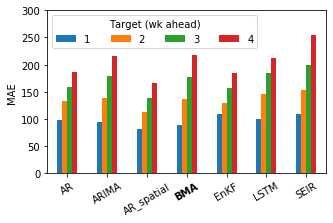

In [146]:
plt.rcParams.update({'font.size': 10})
fig,ax=plt.subplots(1,1,figsize=(5,3))
amdf[amdf.true>10].groupby(['method','step_ahead'],as_index=True).mean()[['MAE']].unstack(1).plot(kind='bar',ax=ax,rot=30)
ax.legend(['1','2','3','4'],title='Target (wk ahead)',ncol=4)
ax.set_ylabel('MAE')
ax.set_xlabel('')
ax.set_ylim([0,300])
ax.get_xticklabels()[3].set_weight("bold")
# plt.savefig('plots/overall_perf_BMA_v3.pdf',bbox_inches='tight')

In [303]:
uamdf=amdf[amdf.method!='BMA'].groupby(['cnty','horizon','fct_date','step_ahead'],as_index=False).mean()

In [308]:
uamdf['method']='Uniform'

In [309]:
amdf=amdf.append(uamdf,sort=True)

In [319]:
amdf=amdf[amdf.method!='Uniform']

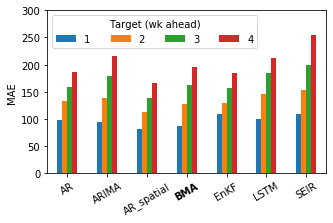

In [320]:
plt.rcParams.update({'font.size': 10})
fig,ax=plt.subplots(1,1,figsize=(5,3))
amdf[amdf.true>10].groupby(['method','step_ahead'],as_index=True).mean()[['MAE']].unstack(1).plot(kind='bar',ax=ax,rot=30)
ax.legend(['1','2','3','4'],title='Target (wk ahead)',ncol=4)
ax.set_ylabel('MAE')
ax.set_xlabel('')
ax.set_ylim([0,300])
ax.get_xticklabels()[3].set_weight("bold")
# plt.savefig('plots/overall_perf_BMA_v3.pdf',bbox_inches='tight')

In [74]:
ll=[]
for i in range(2):
    for j in range(2):
        ll.append([i,j])

In [75]:
amdf[amdf.MAE==amdf.MAE.max()]

,cnty,horizon,method,fct_date,step_ahead,fct_mean,fct_std,true,MAE
182173,06037,2020-12-06,SEIR,2021-01-03,4-step_ahead,201790.0,35123.227041,99892.0,101898.0
19863,06037,2020-12-06,BMA,2021-01-03,4-step_ahead,201790.0,57695.035778,99892.0,101898.0


In [1242]:
tabledf.cnty=tabledf.cnty.replace(mapname)

In [311]:
# tabledf

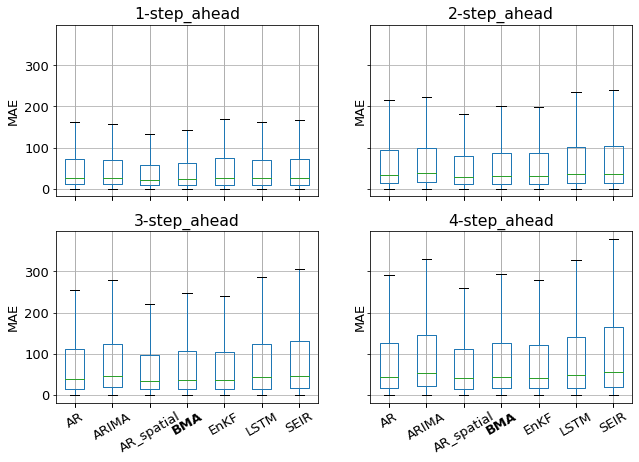

In [322]:
plt.rcParams.update({'font.size': 13})
fig,axr=plt.subplots(2,2,figsize=(10,7),sharex=True, sharey=True)
i=0; j=0
k=0
for stp in amdf['step_ahead'].unique():
    ax=axr[ll[k][0]][ll[k][1]]
    amdf[(amdf.step_ahead==stp)&(amdf.true>10)][['method','MAE']].boxplot(by='method',showfliers=False,ax=ax,rot=30)
#     ax.set_ylim([0,300])
    ax.set_ylabel('MAE')
    ax.set_xlabel('')
    ax.set_title(stp)
    if ll[k][0]==1:
        ax.get_xticklabels()[3].set_weight("bold")
    k+=1

    
    
#     ax.get_xticklabels()[3].set_weight("bold")
#     pdb.set_trace()

plt.suptitle('')
plt.savefig('plots/boxplot_overall_MAE_v3.pdf',bbox_inches='tight')


Text(0.5, 0.98, '')

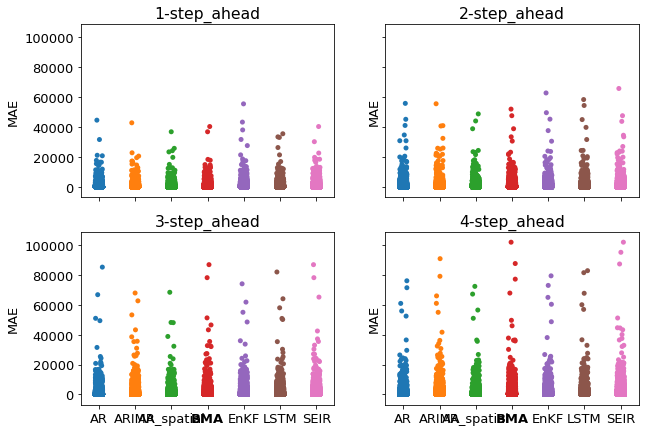

In [328]:
plt.rcParams.update({'font.size': 13})
fig,axr=plt.subplots(2,2,figsize=(10,7),sharex=True, sharey=True)
i=0; j=0
k=0
for stp in amdf['step_ahead'].unique():
    ax=axr[ll[k][0]][ll[k][1]]
    tpdf=amdf[(amdf.step_ahead==stp)&(amdf.true>10)][['method','MAE']]#.boxplot(by='method',showfliers=False,ax=ax,rot=30)
    tpdf=tpdf.sort_values('method')
#     ax.set_ylim([0,300])
    sns.stripplot(x='method',y='MAE',data=tpdf,ax=ax)
    ax.set_ylabel('MAE')
    ax.set_xlabel('')
    ax.set_title(stp)
    if ll[k][0]==1:
        ax.get_xticklabels()[3].set_weight("bold")
    k+=1

    
    
#     ax.get_xticklabels()[3].set_weight("bold")
#     pdb.set_trace()

plt.suptitle('')
# plt.savefig('plots/boxplot_overall_MAE_v3.pdf',bbox_inches='tight')

In [317]:
amdf['fct_date']=pd.to_datetime(amdf['fct_date'],format='%Y-%m-%d')
# amdf['fct_date']=amdf['fct_date'].dt.strftime('%Y-%m-%d')

In [79]:
usdf=pd.DataFrame(columns=new_df.columns)
usdf.loc['US weekly inc cases',:]=new_df.loc[:,:].sum()
usdf=usdf.T
usdf.index=pd.to_datetime(usdf.index,format='%Y-%m-%d')

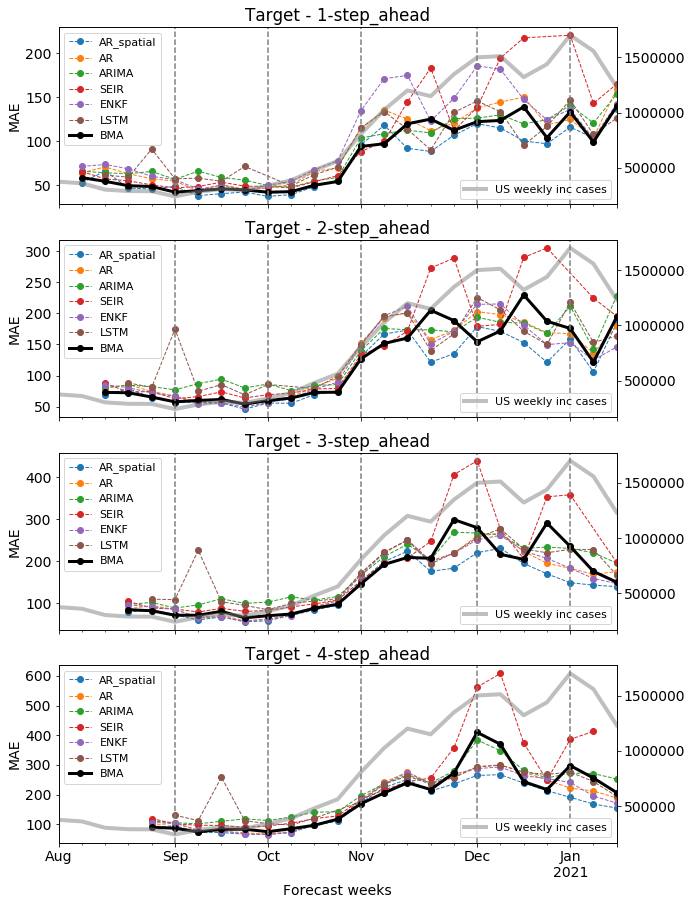

In [81]:
plt.rcParams.update({'font.size': 14})
mtds=amdf.method.unique()
fig,axr=plt.subplots(4,1,figsize=(10,15))
k=0
for stp in amdf.step_ahead.unique():
    ax=axr[k]
    if k!=3:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Forecast date')
    ax.set_ylabel('MAE')
    for mtd in mtds:

        if mtd=='BMA':
            lw=3
            ls='-'
            amdf[(amdf.true>10)&(amdf.step_ahead==stp)&(amdf.method==mtd)][['cnty','fct_date','method','MAE']].groupby(['method','fct_date'],as_index=False).mean().plot(x='fct_date',y='MAE',ax=ax,linewidth=lw,label=mtd,marker='o',linestyle=ls,color='black')
        else:
            lw=1
            ls='--'
            amdf[(amdf.true>10)&(amdf.step_ahead==stp)&(amdf.method==mtd)][['cnty','fct_date','method','MAE']].groupby(['method','fct_date'],as_index=False).mean().plot(x='fct_date',y='MAE',ax=ax,linewidth=lw,label=mtd,marker='o',linestyle=ls)
    k+=1
    ax.axvline(x='2020-09-01',color='gray',linestyle='--')
    ax.axvline(x='2020-10-01',color='gray',linestyle='--')
    ax.axvline(x='2020-11-01',color='gray',linestyle='--')
    ax.axvline(x='2020-12-01',color='gray',linestyle='--')
    ax.axvline(x='2021-01-01',color='gray',linestyle='--')
    ax.set_title('Target - {}'.format(stp))
    ax.legend(fontsize=11)
    ax2=ax.twinx()
    usdf.loc['2020-08-02':'2021-01-17'].plot(ax=ax2,color='gray',linewidth=4,alpha=0.5)
    ax2.legend(loc='lower right',fontsize=11)
ax.set_xlabel('Forecast weeks')
# plt.savefig('plots/median_bma_methods_week_perf_v2.pdf',bbox_inches='tight')

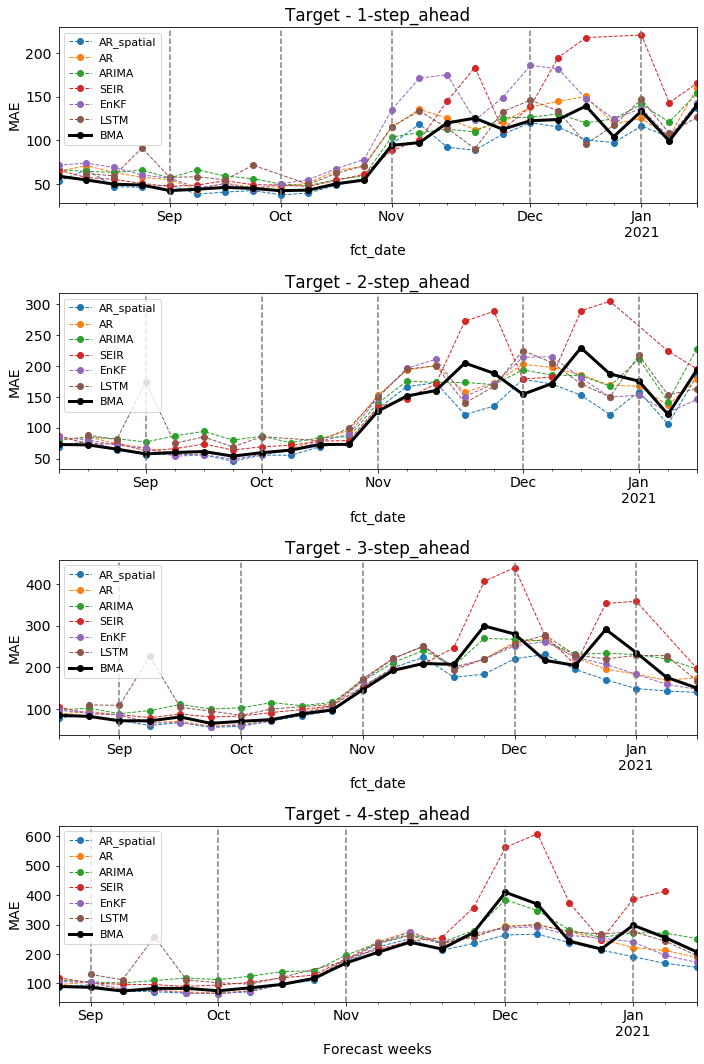

In [334]:
plt.rcParams.update({'font.size': 14})
mtds=amdf.method.unique()
fig,axr=plt.subplots(4,1,figsize=(10,15))
k=0
for stp in amdf.step_ahead.unique():
    ax=axr[k]
    if k!=3:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Forecast date')
    ax.set_ylabel('MAE')
    for mtd in mtds:

        if mtd=='BMA':
            lw=3
            ls='-'
            amdf[(amdf.true>10)&(amdf.step_ahead==stp)&(amdf.method==mtd)][['cnty','fct_date','method','MAE']].groupby(['method','fct_date'],as_index=False).mean().plot(x='fct_date',y='MAE',ax=ax,linewidth=lw,label=mtd,marker='o',linestyle=ls,color='black')
        elif mtd=='Uniform':
            lw=3
            ls='-'
            amdf[(amdf.true>10)&(amdf.step_ahead==stp)&(amdf.method==mtd)][['cnty','fct_date','method','MAE']].groupby(['method','fct_date'],as_index=False).mean().plot(x='fct_date',y='MAE',ax=ax,linewidth=lw,label=mtd,marker='o',linestyle=ls,color='pink')
        else:
            lw=1
            ls='--'
            amdf[(amdf.true>10)&(amdf.step_ahead==stp)&(amdf.method==mtd)][['cnty','fct_date','method','MAE']].groupby(['method','fct_date'],as_index=False).mean().plot(x='fct_date',y='MAE',ax=ax,linewidth=lw,label=mtd,marker='o',linestyle=ls)
    k+=1
    ax.axvline(x='2020-09-01',color='gray',linestyle='--')
    ax.axvline(x='2020-10-01',color='gray',linestyle='--')
    ax.axvline(x='2020-11-01',color='gray',linestyle='--')
    ax.axvline(x='2020-12-01',color='gray',linestyle='--')
    ax.axvline(x='2021-01-01',color='gray',linestyle='--')
    ax.set_title('Target - {}'.format(stp))
    ax.legend(fontsize=11)
#     ax2=ax.twinx()
#     usdf.loc['2020-08-02':'2021-01-17'].plot(ax=ax2,color='gray',linewidth=4,alpha=0.5)
#     ax2.legend(loc='lower right',fontsize=11)
ax.set_xlabel('Forecast weeks')
plt.tight_layout()
plt.savefig('plots/mean_bma_methods_week_perf_v3.pdf',bbox_inches='tight')

In [316]:
        amdf[(amdf.true>10)&(amdf.step_ahead==stp)&(amdf.method==mtd)][['cnty','fct_date','method','MAE']].groupby(['method','fct_date'],as_index=False).mean().plot(x='fct_date',y='MAE',ax=ax,linewidth=lw,label=mtd,marker='o',linestyle=ls)

TypeError: index type not supported

Text(0.5, 0, 'Forecast weeks')

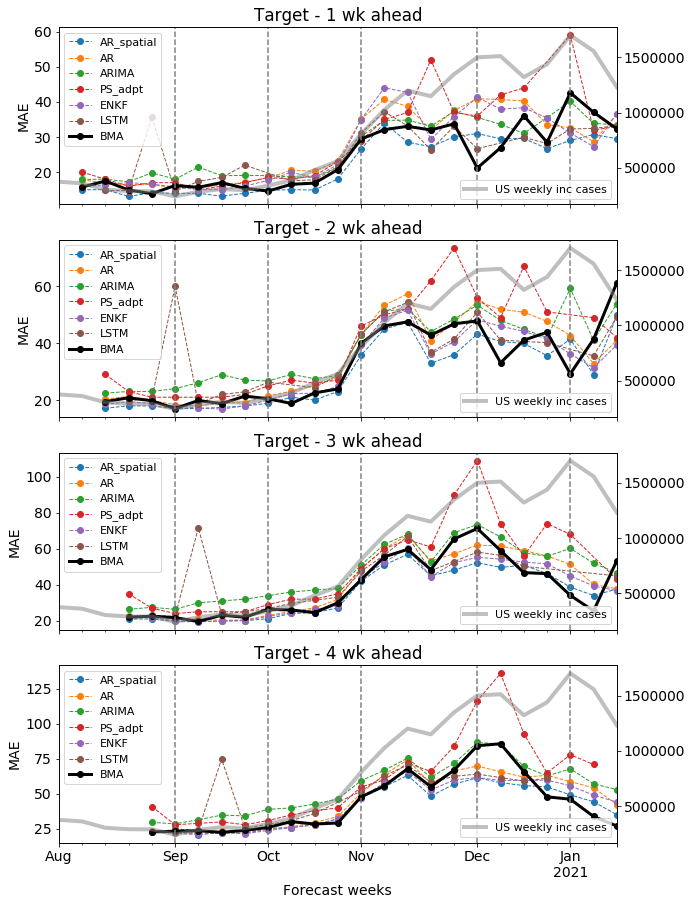

In [280]:
plt.rcParams.update({'font.size': 14})
mtds=amdf.method.unique()
fig,axr=plt.subplots(4,1,figsize=(10,15))
k=0
for stp in amdf.step_ahead.unique():
    ax=axr[k]
    if k!=3:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Forecast date')
    ax.set_ylabel('MAE')
    for mtd in mtds:

        if mtd=='BMA':
            lw=3
            ls='-'
            amdf[(amdf.true>10)&(amdf.step_ahead==stp)&(amdf.method==mtd)][['cnty','fct_date','method','MAE']].groupby(['method','fct_date'],as_index=False).median().plot(x='fct_date',y='MAE',ax=ax,linewidth=lw,label=mtd,marker='o',linestyle=ls,color='black')
        else:
            lw=1
            ls='--'
            amdf[(amdf.true>10)&(amdf.step_ahead==stp)&(amdf.method==mtd)][['cnty','fct_date','method','MAE']].groupby(['method','fct_date'],as_index=False).median().plot(x='fct_date',y='MAE',ax=ax,linewidth=lw,label=mtd,marker='o',linestyle=ls)
    k+=1
    ax.axvline(x='2020-09-01',color='gray',linestyle='--')
    ax.axvline(x='2020-10-01',color='gray',linestyle='--')
    ax.axvline(x='2020-11-01',color='gray',linestyle='--')
    ax.axvline(x='2020-12-01',color='gray',linestyle='--')
    ax.axvline(x='2021-01-01',color='gray',linestyle='--')
    ax.set_title('Target - {}'.format(stp))
    ax.legend(fontsize=11)
    ax2=ax.twinx()
    usdf.loc['2020-08-02':'2021-01-17'].plot(ax=ax2,color='gray',linewidth=4,alpha=0.5)
    ax2.legend(loc='lower right',fontsize=11)
ax.set_xlabel('Forecast weeks')
# plt.savefig('plots/median_bma_methods_week_perf.pdf',bbox_inches='tight')

In [82]:
amdf['rank']=amdf.groupby(['cnty','fct_date','horizon'])['MAE'].rank("dense", ascending=True)

In [83]:
totpop=popdf['population'].sum()
popdf['popfrac']=popdf['population']/totpop

In [426]:
popcn=popdf[popdf.population>=1e6].FIPS.unique()
# popdf[popdf.population>=1e6].sort_values(['population'],ascending=False)

In [427]:
len(bmadf.horizon.unique())

25

In [428]:
amdf[(~amdf.cnty.isin(popcn))&(amdf.true>10)&(amdf['rank']==1)].groupby(['method']).sum()['rank']

method
AR            28855.0
ARIMA         29111.0
AR_spatial    34507.0
BMA           24252.0
ENKF          31559.0
LSTM          35880.0
PS_adpt       48822.0
Name: rank, dtype: float64

In [141]:
# bmadf[colbma]
bmadf['method']=bmadf['method'].map({'BMA-true':'BMA-Fixed_Mean','BMA-adj':'BMA-Var_mean'})
bmadf['step_ahead']=bmadf['step_ahead'].map({'1-step_ahead':'1 wk ahead','2-step_ahead':'2 wk ahead','3-step_ahead':'3 wk ahead','4-step_ahead':'4 wk ahead'})

In [142]:
# bmadf#.groupby(['method','step_ahead'],as_index=True).mean()[['AE']]

In [143]:
bmadf['MAE']=np.abs(bmadf['true']-bmadf['fct_mean'])

In [255]:
# fig,ax=plt.subplots(1,1,figsize=(5,3))
# bmadf.groupby(['method','step_ahead'],as_index=True).mean()[['MAE']].unstack(0).plot(kind='bar',ax=ax,rot=0)#[['method','step_ahead','AE']].plot(x='method',y='AE',kind='bar')
# ax.legend(['BMA-Fixed_Mean','BMA-Var_Mean'])
# ax.set_ylabel('MAE')
# ax.set_xlabel('Horizon')
# # plt.savefig('plots/muliple_form_BMA.pdf',bbox_inches='tight')

In [39]:
# fig,ax=plt.subplots(1,1,figsize=(5,3))
# bmadf.groupby(['method','step_ahead'],as_index=True).mean()[['MAE']].unstack(0).plot(kind='bar',ax=ax,rot=0)#[['method','step_ahead','AE']].plot(x='method',y='AE',kind='bar')
# ax.legend(['BMA-Fixed_Mean','BMA-Var_Mean'])
# ax.set_ylabel('MAE')
# ax.set_xlabel('Horizon')
# plt.savefig('plots/muliple_form_BMA.pdf',bbox_inches='tight')

In [80]:
# # wtdf[(wtdf.cnty=='01005')&(wtdf.horizon=='2020-08-09')&(wtdf.step_ahead=='1-step_ahead')]
# wtdf[(wtdf.horizon=='2020-11-01')&(wtdf.cnty=='01001')]

In [146]:
# tdf=pd.DataFrame()
# for mtd in ['AR_spatial','AR','ARIMA','PatchSim','kalman','lstm']:#,'PatchSim','kalman','lstm','lstm_snapshot']:#'AR_spatial_mob','mob',,'AR_spatial_mob','lstm_snapshot','AR_exog'
#     tdf=tdf.append(pd.read_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/{}/merged.csv'.format(mtd)))

# tdf.cnty=pd.to_numeric(tdf.cnty)
# tdf.cnty=tdf.cnty.apply(lambda x: '{:05}'.format(int(x)))

In [1075]:
# bmadf=pd.DataFrame()
# for w in ['true']:
#     print(w)
#     temp=pd.read_csv('output/{}_weeks_wts_newcomp_true_v2.csv'.format(sdt),dtype={'cnty':str})
#     temp=temp.rename(columns={'wts':'wts_{}'.format(w),'sig':'sig_{}'.format(w)})
#     wtdf=tdf[tdf.horizon==sdt].merge(temp)
#     wtdf.loc[wtdf[wtdf.fct_lb<0].index,'fct_lb']=0
#     wtdf.loc[wtdf[wtdf.fct_ub<0].index,'fct_ub']=0
#     if w=='adj':
#         coltemp='fct_adj'
#     elif w=='true':
#         coltemp='fct_mean'
#     wtdf['w_fct_mean']=wtdf[coltemp]*wtdf['wts_{}'.format(w)]
#     wtdf['sig_2']=wtdf['wts_{}'.format(w)]*wtdf['sig_{}'.format(w)]**2
#     wtdf['w_fct_mean_2']=wtdf['wts_{}'.format(w)]*wtdf['fct_mean'.format(w)]**2
#     wttdf=wtdf.groupby(['cnty','horizon','fct_date','step_ahead'],as_index=False).sum()
#     wttdf['w_sig_2']=(wttdf['sig_2']+wttdf['w_fct_mean_2']-wttdf['w_fct_mean']**2)
#     wttdf['method']='BMA_ensemble'.format(w)
#     ind1=wttdf[wttdf['w_sig_2']<0].index
#     wttdf.loc[ind1,'w_sig_2']=wttdf.loc[ind1,'sig_2']
#     wttdf['w_sig']=np.sqrt(wttdf['w_sig_2'])
#     bmadf=bmadf.append(wttdf,sort=True)

In [148]:
bmadf.loc[:,'fct_mean']=bmadf.loc[:,'w_fct_mean']
bmadf.loc[:,'fct_std']=bmadf.loc[:,'w_sig']
bmadf.loc[:,'fct_lb']=bmadf.loc[:,'fct_mean']-bmadf.loc[:,'fct_std']
bmadf.loc[:,'fct_ub']=bmadf.loc[:,'fct_mean']+bmadf.loc[:,'fct_std']

In [149]:
col1=['cnty', 'fct_date', 'fct_lb', 'fct_mean', 'fct_std', 'fct_ub','horizon', 'method','step_ahead','true']

In [150]:
bmadf=bmadf[col1]

In [151]:
amdf=tdf[tdf.horizon==sdt][col1].append(bmadf[col1],sort=True)

In [774]:
amdf.to_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/ensemble/BMA/{}_all_methods_ensemble.csv'.format(sdt),index=None)

In [775]:
subdt=(datetime.strptime(sdt,'%Y-%m-%d')+timedelta(days=8)).strftime('%Y-%m-%d')
bmadf.to_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/ensemble/BMA/{}_BMA_ensemble.csv'.format(sdt),index=None)

In [112]:
from statsmodels.iolib.smpickle import load_pickle

In [116]:
mod=load_pickle('/sfs/qumulo/qproject/biocomplexity/aniadiga/Forecasting/covid19_ARLR/pkl/AR_spatial/06037_2021-01-17_1-step_spatial.pkl')

In [152]:
fipsdf=pd.read_csv('input/fips_map.csv',dtype={'FIPS':str,'St_code':str})

In [153]:
# dictfips=fipsdf[['FIPS','State_code']].rename(columns={'FIPS':'cnty'})

In [131]:
part=40
for ss in fipsdf.location_code.unique():
    ind=fipsdf[fipsdf.location_code==ss].index
    cntyls=list(fipsdf[fipsdf.location_code=='TX']['cnty'])
    len_ind=len(ind)
    ll=[ind[i*part:(i+1)*part] for i in range(int(np.ceil(len_ind/part)))]
    k=0
    for l in ll:
        fipsdf.loc[l,'prtsn']=fipsdf.loc[l,'location_code']+'_'+str(int(k))
        k+=1

In [136]:
sdir='/sfs/qumulo/qproject/biocomplexity/aniadiga/Forecasting/covid19_ARLR/splitfiles/'

In [151]:
with open('/sfs/qumulo/qproject/biocomplexity/aniadiga/Forecasting/covid19_ARLR/splitfiles/statewise_list.txt','w') as f1:
    for st in fipsdf.prtsn.unique():
        ll=fipsdf[fipsdf.prtsn==st]['FIPS'].unique()
        fl='{}{}_cnty_list.txt'.format(sdir,st)
        with open('/sfs/qumulo/qproject/biocomplexity/aniadiga/Forecasting/covid19_ARLR/splitfiles/statewise_list.txt','w') as f:
            f1.write("%s\n" % fl)
        with open(fl,'w') as f:
            for l in ll:
                f.write("%s\n" % l)

### Weights analysis

In [101]:
cumdf=pd.DataFrame(index=new_df.index)
cumdf['cum_cases']=new_df.loc[:].sum(axis=1)
cumdf=cumdf.reset_index().rename(columns={'FIPS':'cnty'})
cumcn=cumdf.sort_values('cum_cases',ascending=False).head(20).cnty.unique()

In [84]:
wdf=pd.read_csv('output/all_weeks_wts_newcomp_true_v4.csv'.format(mtd),dtype={'cnty':str})
# hwdf=wdf[wdf.wts>=.75]

In [85]:
# wdf[wdf.wts>0.25].groupby(['method','step_ahead']).count()['wts'].unstack(0).plot(kind='bar',rot=30)
# plt.title('weights>0.25')
# plt.legend(fontsize=10,ncol=2)

In [86]:
popcn=new_df.sum(axis=1).sort_values(ascending=False)[:10].index.values ##top 10 counties

In [87]:
mnewdf['filt']=mnewdf['cnty']+'_'+mnewdf['fct_date']

In [88]:
wdf['filt']=wdf['cnty']+'_'+wdf['horizon']

In [949]:
filtlist=mnewdf[(mnewdf.true>=10)&(mnewdf.fct_date>='2020-08-02')]['filt'].values

In [727]:
wdf=wdf[wdf.filt.isin(filtlist)]

In [112]:
hwdf=wdf[wdf.wts>0.5].groupby(['cnty','horizon','step_ahead','method'])[['wts']].count()
hwdf=hwdf.rename(columns={'wts':'cnt'})
hwdf=hwdf.reset_index()

In [113]:
mhwdf=hwdf.groupby(['cnty','step_ahead','method']).sum()[['cnt']]
mhwdf=mhwdf.reset_index()

In [115]:
# popdf=popdf.rename(columns={'cnty':'cnty_st','FIPS':'cnty'})#['cnty','population']

In [116]:
mhwdf=mhwdf.merge(popdf[['cnty','population']],on='cnty')

In [117]:
mhwdf=mhwdf.merge(cumdf[['cnty','cum_cases']],on='cnty')

In [140]:
phwdf=mhwdf.loc[mhwdf.groupby(['cnty','step_ahead'])['cnt'].idxmax()].sort_values('cum_cases',ascending=False)

In [141]:
mask=(phwdf.step_ahead=='1-step_ahead')&(phwdf.cnty.isin(cumcn))
phwdf=phwdf[mask].loc[phwdf[mask].groupby(['cnty'])['cnt'].idxmax()]

In [119]:
cumdf[cumdf.cnty.isin(popcn)]['cnty'].replace(mapfips)

108              Maricopa_Arizona
213        Los Angeles_California
224             Orange_California
228          Riverside_California
231     San Bernardino_California
232          San Diego_California
382                         12086
640                 Cook_Illinois
2750                 Dallas_Texas
2794                 Harris_Texas
Name: cnty, dtype: object

In [229]:
popdf

,cnty,population,location_name,cnty_st,popfrac
0,01001,55869.0,Autauga County,Autauga_AL,0.000170
1,01003,223234.0,Baldwin County,Baldwin_AL,0.000680
2,01005,24686.0,Barbour County,Barbour_AL,0.000075
3,01007,22394.0,Bibb County,Bibb_AL,0.000068
4,01009,57826.0,Blount County,Blount_AL,0.000176
5,01011,10101.0,Bullock County,Bullock_AL,0.000031
6,01013,19448.0,Butler County,Butler_AL,0.000059
7,01015,113605.0,Calhoun County,Calhoun_AL,0.000346
8,01017,33254.0,Chambers County,Chambers_AL,0.000101
9,01019,26196.0,Cherokee County,Cherokee_AL,0.000080


In [150]:
fipsdf=pd.read_csv('../misc_data/US_fips_codes_names.csv')
fipsdf['FIPS']=fipsdf.FIPS.apply(lambda x: '{:05}'.format(x))
mapfips=dict(zip(fipsdf['FIPS'],fipsdf['County']+'_'+fipsdf['State_code']))
mapname=dict(zip(fipsdf['County']+'_'+fipsdf['State_code'],fipsdf['FIPS']))


In [143]:
cols=phwdf.columns
k=0
for i in phwdf.index:
    tmp=phwdf.loc[i]
#     print(tmp[cols[0]])
    bmavar=abdf[(abdf.cnty==tmp[cols[0]])&(abdf.step_ahead==tmp[cols[1]])&(abdf.method=='BMA-ensemble')][['MAE']].mean().values[0]
    abvar=abdf[(abdf.cnty==tmp[cols[0]])&(abdf.step_ahead==tmp[cols[1]])&(abdf.method=='No-'+tmp[cols[2]])][['MAE']].mean().values[0]
    pc=100*(abvar-bmavar)/(bmavar)
    phwdf.loc[i,'per_ch']=pc
    phwdf.loc[i,'Method_dropped']=tmp[cols[2]]
    k+=1

In [151]:
# fipsdf[fipsdf.FIPS=='06037']
tabledf=phwdf.rename(columns={'cnt':'# weeks picked','per_ch':'% change'})
t1=tabledf[tabledf.cnty.isin(['04013','06037','06071','36047'])]
# tabledf.cnty=tabledf.cnty.replace(mapfips)
t1['Most picked method']=t1['method']+' ('+t1['# weeks picked'].astype(str)+')'
t1.cnty=t1.cnty.replace(mapfips)


/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [158]:
# mapfips['12086']='Miami-Dade_FL'
with open('output/ablation_table.tex','w') as f:
    f.write(t1[['cnty','Most picked method','Method_dropped','% change']].to_latex())

In [1211]:
tabledf.to_csv('output/top_cnty_change_in_MAE.csv',index=None)

24

### ablation

In [132]:
for mtd in tdf.method.unique():
    awdf=pd.DataFrame()
    for dt in tqdm(dtlist):
        awdf=awdf.append(pd.read_csv('output/ablation/all_weeks_wts_newcomp_no_{}_{}.csv'.format(mtd,dt)))
    awdf.to_csv('output/all_weeks_wts_newcomp_no_{}.csv'.format(mtd))

In [133]:
mtdlist=tdf.method.unique()
abdf=pd.DataFrame()
for mtd in mtdlist:
    print(mtd)
    temp=pd.read_csv('output/all_weeks_wts_newcomp_no_{}.csv'.format(mtd),dtype={'cnty':str})
    temp.cnty=pd.to_numeric(temp.cnty)
    temp.cnty=temp.cnty.apply(lambda x: '{:05}'.format(int(x)))
    temp=temp.rename(columns={'wts':'wts_{}'.format(w),'sig':'sig_{}'.format(w)})
    wtdf=tdf.merge(temp)
    wtdf.loc[wtdf[wtdf.fct_lb<0].index,'fct_lb']=0
    wtdf.loc[wtdf[wtdf.fct_ub<0].index,'fct_ub']=0
    if w=='adj':
        coltemp='fct_adj'
    elif w=='true':
        coltemp='fct_mean'
    wtdf['w_fct_mean']=wtdf[coltemp]*wtdf['wts_{}'.format(w)]
    wtdf['true']=wtdf['true']*wtdf['wts_{}'.format(w)]
    wtdf['sig_2']=wtdf['wts_{}'.format(w)]*wtdf['sig_{}'.format(w)]**2
    wtdf['w_fct_mean_2']=wtdf['wts_{}'.format(w)]*wtdf['fct_mean'.format(w)]**2
    wttdf=wtdf.groupby(['cnty','horizon','fct_date','step_ahead'],as_index=False).sum()
    wttdf['w_sig_2']=(wttdf['sig_2']+wttdf['w_fct_mean_2']-wttdf['w_fct_mean']**2)
    wttdf['method']='No-{}'.format(mtd)
    ind1=wttdf[wttdf['w_sig_2']<0].index
    wttdf.loc[ind1,'w_sig_2']=wttdf.loc[ind1,'sig_2']
    wttdf['w_sig']=np.sqrt(wttdf['w_sig_2'])
    abdf=abdf.append(wttdf,sort=True)
abdf=abdf.drop('Unnamed: 0',axis=1)

AR_spatial
AR
ARIMA
PatchSim_adpt
ENKF
lstm


In [135]:
# abdf[abdf.method=='BMA-ens'].columns
abdf.method.unique()

array(['No-AR_spatial', 'No-AR', 'No-ARIMA', 'No-PatchSim_adpt',
       'No-ENKF', 'No-lstm'], dtype=object)

In [136]:
cnlist=abdf.cnty.unique()

In [137]:
abdf=abdf[colbma].append(bmadf[colbma],sort=True)

In [138]:
abdf['MAE']=np.abs(abdf['true']-abdf['fct_mean'])

In [876]:
# abdf.merge
abdf=abdf.merge(popdf[['FIPS','population']].rename(columns={'FIPS':'cnty'}),on='cnty')

In [877]:
bmadf['MAE']=bmadf['fct_mean']-bmadf['true']

In [880]:
abdf[(abdf.cnty=='06037')&(abdf.step_ahead=='1-step_ahead')&(abdf.method=='No-PatchSim_adpt')][['cnty','MAE']].mean()

cnty    2.414824e+122
MAE      1.378354e+05
dtype: float64

In [885]:
abdf[(abdf.cnty=='06037')&(abdf.step_ahead=='1-step_ahead')&(abdf.method=='BMA-ensemble')][['cnty','fct_mean','','MAE']].mean()

cnty    2.414824e+122
MAE      7.591903e+03
dtype: float64

In [857]:
seldf=abdf[(abdf.cnty.isin(popcn))].groupby(['cnty','method','step_ahead']).mean()

In [223]:
mtddict={'BMA-ensemble':'All','No-PatchSim_adpt':'No-PS_adpt','No-lstm':'No-LSTM','PatchSim-adpt':'PS-adpt','lstm':'LSTM'}
stpdict={'1-step_ahead':'1 wk ahead','2-step_ahead':'2 wk ahead','3-step_ahead':'3 wk ahead','4-step_ahead':'4 wk ahead'}
abdf['method']=abdf['method'].replace(mtddict)
abdf['step_ahead']=abdf['step_ahead'].replace(stpdict)

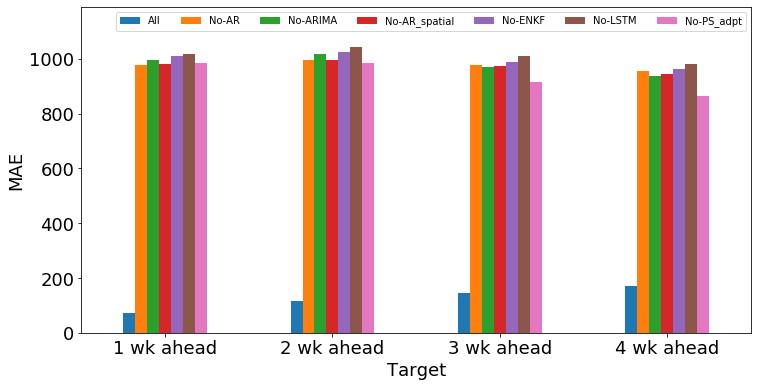

In [228]:
plt.rcParams.update({'font.size': 18})
fig,ax=plt.subplots(1,1,figsize=(12,6))
abdf.groupby(['method','step_ahead']).mean()['MAE'].unstack(0).plot(kind='bar',rot=0,ax=ax)
ax.legend(title='',ncol=7,fontsize=10)
ax.set_ylabel('MAE')
ax.set_xlabel('Target')
ax.set_ylim([0,1190])
plt.savefig('plots/ablation_overall_v2.pdf',bbox_inches='tight')

Text(0.5, 0, 'Target')

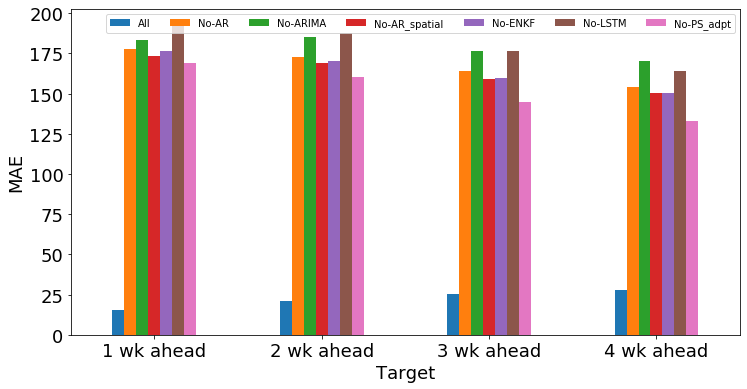

In [254]:
plt.rcParams.update({'font.size': 18})
fig,ax=plt.subplots(1,1,figsize=(12,6))
abdf.groupby(['method','step_ahead']).median()['MAE'].unstack(0).plot(kind='bar',rot=0,ax=ax)
ax.legend(title='',ncol=7,fontsize=10)
ax.set_ylabel('MAE')
ax.set_xlabel('Target')
# ax.set_ylim([0,1000])
# plt.savefig('plots/ablation_overall.pdf',bbox_inches='tight')

In [260]:
abdf.columns

Index(['cnty', 'fct_date', 'fct_mean', 'fct_std', 'horizon', 'method',
       'step_ahead', 'true', 'MAE', 'population'],
      dtype='object')

In [266]:
alldf=abdf[abdf.method=='All'][['cnty', 'fct_date', 'fct_mean', 'horizon',
       'step_ahead', 'true', 'MAE']]
alldf=alldf.rename(columns={'true':'true_all','fct_mean':'fct_mean_all','MAE':'MAE_all'})

In [269]:
mabdf=abdf.merge(alldf)

In [271]:
mabdf['MAE_ratio']=mabdf['MAE']/mabdf['MAE_all']

,cnty,step_ahead,method,# weeks picked,population,cum_cases,% change,Method_dropped
1802,Maricopa_AZ,1-step_ahead,PatchSim_adpt,8,4485414.0,477031,1576.106433,PatchSim_adpt
3596,Los Angeles_CA,1-step_ahead,AR_spatial,10,10039107.0,1124980,1678.711406,AR_spatial
3798,Orange_CA,1-step_ahead,AR_spatial,17,3175692.0,247891,1030.988257,AR_spatial
3851,Riverside_CA,1-step_ahead,ARIMA,9,2470546.0,276938,1397.033555,ARIMA
3904,San Bernardino_CA,1-step_ahead,ARIMA,11,2180085.0,275380,999.031340,ARIMA
3924,San Diego_CA,1-step_ahead,PatchSim_adpt,6,3338330.0,240055,1968.207820,PatchSim_adpt
5730,Broward_FL,1-step_ahead,ARIMA,5,1952778.0,174685,1869.952946,ARIMA
6412,12086,1-step_ahead,PatchSim_adpt,14,2716940.0,375329,1272.184534,PatchSim_adpt
10806,Cook_IL,1-step_ahead,AR_spatial,6,5150233.0,455142,1516.325889,AR_spatial
31218,Clark_NV,1-step_ahead,PatchSim_adpt,7,2266715.0,215475,1683.098161,PatchSim_adpt


### CDC format quantile

In [286]:
hrzn_list=bmadf.horizon.unique()

In [287]:
dts=[]
for hrzn in hrzn_list:
    subdt=(datetime.strptime(hrzn,'%Y-%m-%d')+timedelta(days=8)).strftime('%Y-%m-%d')
    dts.append(subdt)
    bmadf[bmadf.horizon==hrzn].to_csv('output/BMA/{}_BMA_ensemble.csv'.format(subdt),index=None)

In [289]:
with open('input/bma_hrzn_file.txt','w') as f:
    for ll in dts:
        f.writelines("%s\n" % ll)

In [290]:
tf='input/bma_hrzn_file.txt'

In [291]:
%%bash -s "$tf"
while IFS= read -r tt
do
python quantile_conversion.py output/BMA/old_format/${tt}_BMA_ensemble.csv $tt output/BMA/cdc_format/${tt}_BMA_ensemble.csv
done < $1

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7

In [292]:
outdir='output/BMA/cdc_format/'
for fl in os.listdir(outdir):
    df=pd.read_csv(outdir+fl)
    temp=(df[df.type=='quantile'].groupby(['location','target'],as_index=False)['value'].diff().fillna(0)>=0).all()
    print(fl,temp)

2020-10-26_BMA_ensemble.csv True
2020-10-12_BMA_ensemble.csv True
2021-01-25_BMA_ensemble.csv True
2020-10-05_BMA_ensemble.csv True
2020-08-31_BMA_ensemble.csv True
2021-01-18_BMA_ensemble.csv True
2020-09-21_BMA_ensemble.csv True
2020-12-07_BMA_ensemble.csv True
2020-11-02_BMA_ensemble.csv True
2020-12-28_BMA_ensemble.csv True
2020-08-10_BMA_ensemble.csv True
2020-09-28_BMA_ensemble.csv True
2020-12-21_BMA_ensemble.csv True
2020-11-23_BMA_ensemble.csv True
2021-01-04_BMA_ensemble.csv True
2020-11-16_BMA_ensemble.csv True
2020-11-09_BMA_ensemble.csv True
2021-01-11_BMA_ensemble.csv True
2020-11-30_BMA_ensemble.csv True
2020-12-14_BMA_ensemble.csv False
2020-08-24_BMA_ensemble.csv True
2020-09-07_BMA_ensemble.csv True
2020-10-19_BMA_ensemble.csv True
2020-08-17_BMA_ensemble.csv True
2020-09-14_BMA_ensemble.csv True


In [221]:
# new_df.loc[:,'2021-01-24']

In [165]:
va_fips=fipsdf[fipsdf.State_code=='VA']['FIPS'].unique()
va_df=pd.DataFrame()
va_df['infections']=new_df.loc[va_fips,'2021-01-24']*5
va_df=va_df.reset_index().rename(columns={'FIPS':'cnty'})
va_df=va_df.merge(popdf[popdf.cnty.isin(va_fips)][['cnty','population']],on='cnty')
va_df['per_inf']=va_df['infections']/va_df['population']
va_df['per_pop']=va_df['population']/8535519.0
for nump in [10000, 20000]:
    va_df['per_pop_to_UVA_{}'.format(nump)]=va_df['per_pop']*nump
    va_df['num_infected_{}'.format(nump)]=va_df['per_pop_to_UVA_{}'.format(nump)]*va_df['per_inf']
va_df['num_infected']=va_df['per_pop_to_UVA']*va_df['per_inf']

In [55]:
cn=popdf.sort_values('population',ascending=False)['FIPS'].unique()[:20]


In [56]:
new_df.loc[cn].sum(axis =1).sum()

5651629

In [57]:
new_df.loc[cn].sum(axis =1).sum()/new_df.sum(axis=1).sum()

0.2099978311433033

In [58]:
2000/3142

0.6365372374283895

In [90]:
new_df.loc['04013']

2020-01-19        1
2020-01-26        1
2020-02-02        1
2020-02-09        1
2020-02-16        1
2020-02-23        1
2020-03-01        1
2020-03-08        2
2020-03-15       45
2020-03-22      405
2020-03-29      717
2020-04-05      720
2020-04-12      600
2020-04-19      743
2020-04-26     1187
2020-05-03     1358
2020-05-10     1317
2020-05-17     1081
2020-05-24     1345
2020-05-31     3239
2020-06-07     5030
2020-06-14    10512
2020-06-21    14071
2020-06-28    17455
2020-07-05    18652
2020-07-12    15389
2020-07-19    13421
2020-07-26    12004
2020-08-02     6250
2020-08-09     3320
2020-08-16     2820
2020-08-23     1704
2020-08-30     2467
2020-09-06     1436
2020-09-13     2294
2020-09-20     1377
2020-09-27     2005
2020-10-04     2879
2020-10-11     3355
2020-10-18     3975
2020-10-25     5584
2020-11-01     6941
2020-11-08     9255
2020-11-15    12679
2020-11-22    16027
2020-11-29    22119
2020-12-06    24537
2020-12-13    26752
2020-12-20    25569
2020-12-27    28593


In [88]:
mapname['Maricopa_Arizona']

'04013'

In [87]:
mapname

{'Autauga_Alabama': '01001',
 'Baldwin_Alabama': '01003',
 'Barbour_Alabama': '01005',
 'Bibb_Alabama': '01007',
 'Blount_Alabama': '01009',
 'Bullock_Alabama': '01011',
 'Butler_Alabama': '01013',
 'Calhoun_Alabama': '01015',
 'Chambers_Alabama': '01017',
 'Cherokee_Alabama': '01019',
 'Chilton_Alabama': '01021',
 'Choctaw_Alabama': '01023',
 'Clarke_Alabama': '01025',
 'Clay_Alabama': '01027',
 'Cleburne_Alabama': '01029',
 'Coffee_Alabama': '01031',
 'Colbert_Alabama': '01033',
 'Conecuh_Alabama': '01035',
 'Coosa_Alabama': '01037',
 'Covington_Alabama': '01039',
 'Crenshaw_Alabama': '01041',
 'Cullman_Alabama': '01043',
 'Dale_Alabama': '01045',
 'Dallas_Alabama': '01047',
 'De Kalb_Alabama': '01049',
 'Elmore_Alabama': '01051',
 'Escambia_Alabama': '01053',
 'Etowah_Alabama': '01055',
 'Fayette_Alabama': '01057',
 'Franklin_Alabama': '01059',
 'Geneva_Alabama': '01061',
 'Greene_Alabama': '01063',
 'Hale_Alabama': '01065',
 'Henry_Alabama': '01067',
 'Houston_Alabama': '01069',
 '